<a href="https://colab.research.google.com/github/tishakbhavsar/practising-pytorch/blob/main/01_pytorch_workflow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# PyTorch Workflow

An example PyTorch end-to-end workflow.

In [2]:
topics_covering = {
    1: "data preparing and loading",
    2: "build model",
    3: "fitting the model to data (training)",
    4: "making predictions and evaluating model",
    5: "saving and loading model",
    6: "putting together"
}

In [3]:
import torch
from torch import nn # nn contains all PyTorch have basic building blocks for computational graphs (NNs)
import matplotlib.pyplot as plt
# nn -> has different types of layers, convolutional layers, pooling layers etc.

# check PyTorch version
torch.__version__

'2.6.0+cu124'

# 1. Data Preparing and Loading

Data can be anything in ML. Excel spreadsheet, videos, images, audio, DNA, text etc

ML is a game of two parts:

1) Get data into a numerical representation (numerical encoding via tensors)

2) Build a model to learn patterns in that numerical operations

Lets create some known data using linear regression. Use LR formula to make a straight line with known parameters.

In [4]:
# Create known parameters

weight = 0.7 # slope
bias = 0.3 # error / Y intercept

# Create
start = 0
end = 1
step = 0.02
X = torch.arange(start, end, step).unsqueeze(dim=1)
y = weight * X + bias

X[:10], y[:10]

(tensor([[0.0000],
         [0.0200],
         [0.0400],
         [0.0600],
         [0.0800],
         [0.1000],
         [0.1200],
         [0.1400],
         [0.1600],
         [0.1800]]),
 tensor([[0.3000],
         [0.3140],
         [0.3280],
         [0.3420],
         [0.3560],
         [0.3700],
         [0.3840],
         [0.3980],
         [0.4120],
         [0.4260]]))

In [5]:
len(X), len(y)

(50, 50)

### Splitting data into training and test sets

Generalization : The ability of ML model to perform well on data it hasn't seen before

In [6]:
# Create a train/test split

train_split = int(0.8 * len(X))
X_train, y_train = X[:train_split], y[:train_split]
X_test, y_test = X[train_split:], y[train_split:]

len(X_train), len(y_train), len(X_test), len(y_test)

(40, 40, 10, 10)

### How can we better visualise our data?

In [7]:
def plot_predictions(train_data = X_train, train_labels = y_train,
                     test_data = X_test, test_labels = y_test, predictions=None):
  """Plots training data, test data and compares predictions."""
  plt.figure(figsize=(10,7))

  plt.scatter(train_data, train_labels, c="b", s=4, label="Training data")

  plt.scatter(test_data, test_labels, c="g", s=4, label="Testing data")

  if predictions is not None:
    # Plot predictions if they exist
    plt.scatter(test_data, predictions, c="r", s=4, label="Predictions")

  plt.legend(prop={"size": 14})


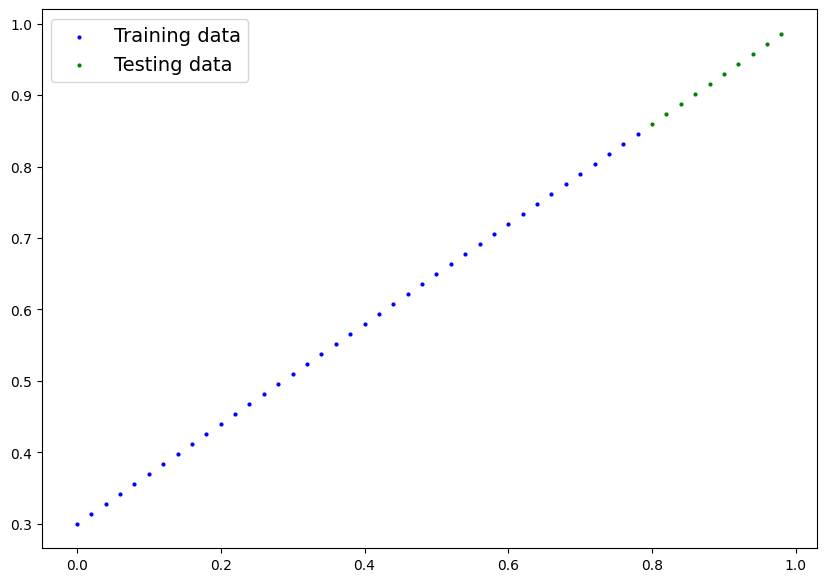

In [8]:
plot_predictions()

## 2. Build Model

In [9]:
# Create a linear regression model class
from torch import nn

# nn.Module -> almost everything in PyTorch inherits from nn.Module, base class for all neural network modules.
class LinearRegressionModel(nn.Module):
  def __init__(self): # constructor
    super().__init__()
    self.weights = nn.Parameter(torch.randn(1,requires_grad=True, dtype=torch.float))
    self.bias = nn.Parameter(torch.randn(1,requires_grad=True, dtype=torch.float))
  # Forward method to define computation in the model
  def forward(self, x: torch.Tensor) -> torch.Tensor: #"x" is input data
      return self.weights * x + self.bias # linear regression formula


### What does our model do?

* Start with random values (weights and bias)
* Look at training data and adjust those random values to better represent the ideal values

### How does it do so?

* Using gradient descent algorithm -> (torch.autograd?)
* Backpropagation

### PyTorch model building essentials

* torch.nn - contains all the building blocks for computational graphs (general term for neural networks).

* torch.nn.parameter - what parameters should our model try and learn, often a PyTorch layer from torch.nn will set these for us

* torch.nn.Module - the base class for all neural network modules. if you subclass it, you should overwrite forward() function.

* torch.optim - this where the optimizers in PT live, they will help with Gradient Descent (optimizer - contains algorithms to optimize the values/parameters)

* def forward() - All nn.Module subclasses are required to overwrite this function. this method defines what happens in forward computation.

### Checking the contents of our PyTorch Model

What is inside the model? We can check our model parameters, using '.parameters()'

In [10]:
# Create a random seed, because we are creating random parameter values

torch.manual_seed(42)

# Create an instance of the model we created

model_0 = LinearRegressionModel()

list(model_0.parameters())

[Parameter containing:
 tensor([0.3367], requires_grad=True),
 Parameter containing:
 tensor([0.1288], requires_grad=True)]

In [11]:
# List named parameters

model_0.state_dict()

OrderedDict([('weights', tensor([0.3367])), ('bias', tensor([0.1288]))])

### Making Predictions using `torch.inference_mode()`

To check model's predictive power, lets see how well it predicts y_test baed on X_test.

When, we pass through data, it is going to run through forward() method.

In [12]:
# Make predictions - use inference_mode
with torch.inference_mode(): # context manager, inference mode turns off gradient tracking!, benefit => predictions will be fast (a lot of things that aren't required aren't being saved!)
  y_preds = model_0(X_test)

# with torch.no_grad: // same, however, inference_mode() is preferred.
y_preds

tensor([[0.3982],
        [0.4049],
        [0.4116],
        [0.4184],
        [0.4251],
        [0.4318],
        [0.4386],
        [0.4453],
        [0.4520],
        [0.4588]])

In [13]:
# y_preds = model_0(X_test) # same as inference mode
# y_preds # difference, here there is a grad function

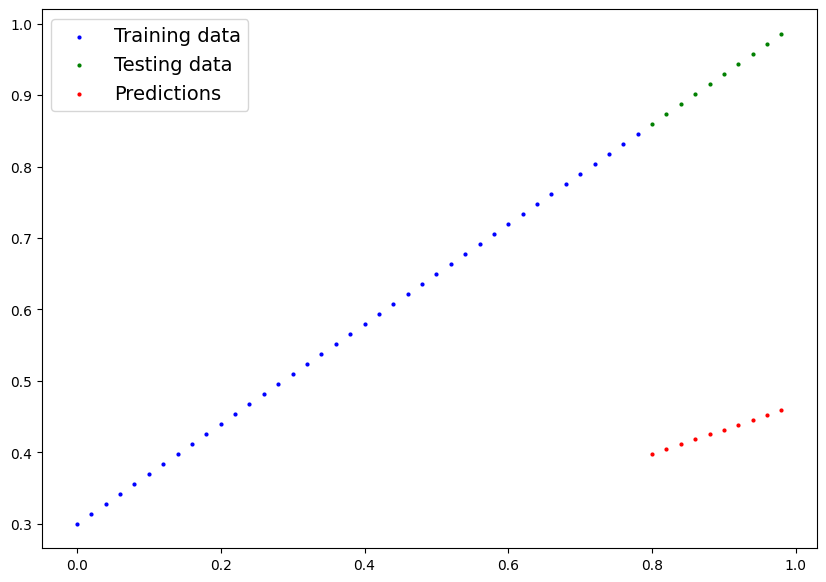

In [14]:
plot_predictions(predictions=y_preds)

### 3. Training

The whole idea of training is for a model to move away from some *unknwon* parameters (these may be random) to some unknown parameters or from a poor representation of data to better representation of data.

We can use a loss function to measure how poorly our model's predictions are. Also called cost function/criterion.

**Loss Function** : A function to measure how wrong your model predictions are compared to actual output.

**Optimizer** : Take into account the loss of a model and adjusts model parameters accordingly (weights and bias), to improve the loss function.

And specifically in PyTorch, we need:

- A training loop
- A testing loop

In [15]:
list(model_0.parameters())

[Parameter containing:
 tensor([0.3367], requires_grad=True),
 Parameter containing:
 tensor([0.1288], requires_grad=True)]

In [16]:
# Check out our model's parameters (a parameter is a value, the model sets itself)
model_0.state_dict()

OrderedDict([('weights', tensor([0.3367])), ('bias', tensor([0.1288]))])

In [17]:
# L1 LOSS - mean absolute error (mae)

# L2 LOSS - mean squared error (mse)

In [18]:
# Set up a loss function
loss_fn = nn.L1Loss() #- mae

# Set up an optimizer - works with loss function, to reduce loss function

# we use SGD - Stochastic Gradient Descent #lr - hyperparam
optimizer = torch.optim.SGD(params = model_0.parameters(), lr=0.01)

### Which loss function and optimizer should I use?

A: This problem will be specific. But with experience, you'll get an idea of what works and what doesn't with your particular problem set.

For eg., for a regression problem (liek ours), a loss function of nn.L1oss() and an optimizer like torch.optim.SGC() will suffice.

But for a classification problem like whether a photo is of a cat or a dog, you'll likely want to use a loss function : nn.BCELoss() (binary cross entropy loss)

### Building a training loop in PyTorch + testing loop

A couple of things we need in a training loop:

0. Loop through the data
1. forward pass (this involves, data moving through our model's forward() function) to make predictions on data - also called forward propagation.
2. Calculate the loss  (compare forward pass predictions to ground truth labels)
3. Optimizer zero grad
4. Loss backward - move backwards through the network to calculate the gradients of the params of our model to the loss (backprop error??)
5. Optimizer step - use optimizer to minimize loss (**gradient descent**)


In [19]:
# An epoch is one loop through the data...(HYPERPARAMTER)
epochs = 100

# Track values
epoch_count = []
loss_values = []
test_loss_values = []


# 0. loop through the data (for epoch times)
for epoch in range(epochs):
     # Set the model to training mode
     model_0.train() # sets all parameters that require grad to require gradients - default mode
     #1. Forward pass:
     y_pred = model_0(X_train)

     #2. Calculate the loss:
     loss = loss_fn(y_pred, y_train)
     print(f'Loss: {loss}')
     #3. Optimizer zero grad
     optimizer.zero_grad()

     #4. Perform backprop on the loss with respect to the parameters of the model
     loss.backward()

     #5. Step the optimizer (perform GD)
     optimizer.step()
    # by default how the optimizer changes will accumulate through the loop, so we have to zero them in step 3 for the next iteration of the loop

     # TESTING :
     model_0.eval() # turns off gradient tracking, turns off different settings in the model not needed for evaluation/testing (dropout/batch norm layers)

     with torch.inference_mode(): # turns off gradient tracking & a couple more things not needed for testing
       # you may also see torch.no_grad() which is a little slower

       # 1. do the forward pass
       test_pred = model_0(X_test)
       # 2. calculate the loss
       test_loss = loss_fn(test_pred, y_test)
     if epoch % 10 == 0:
       epoch_count.append(epoch)
       loss_values.append(loss)
       test_loss_values.append(test_loss)
       print(f'Epoch: {epoch} | Loss: {loss} | Test Loss: {test_loss}')
       print(model_0.state_dict())


Loss: 0.31288138031959534
Epoch: 0 | Loss: 0.31288138031959534 | Test Loss: 0.48106518387794495
OrderedDict([('weights', tensor([0.3406])), ('bias', tensor([0.1388]))])
Loss: 0.3013603389263153
Loss: 0.28983935713768005
Loss: 0.2783183455467224
Loss: 0.26679736375808716
Loss: 0.2552763521671295
Loss: 0.24375534057617188
Loss: 0.23223432898521423
Loss: 0.22071333229541779
Loss: 0.20919232070446014
Loss: 0.1976713240146637
Epoch: 10 | Loss: 0.1976713240146637 | Test Loss: 0.3463551998138428
OrderedDict([('weights', tensor([0.3796])), ('bias', tensor([0.2388]))])
Loss: 0.18615034222602844
Loss: 0.1746293306350708
Loss: 0.16310831904411316
Loss: 0.1515873372554779
Loss: 0.14006635546684265
Loss: 0.1285453587770462
Loss: 0.11702437698841095
Loss: 0.1060912236571312
Loss: 0.09681284427642822
Loss: 0.08908725529909134
Epoch: 20 | Loss: 0.08908725529909134 | Test Loss: 0.21729660034179688
OrderedDict([('weights', tensor([0.4184])), ('bias', tensor([0.3333]))])
Loss: 0.08227583020925522
Loss: 0

In [20]:
model_0.state_dict()

OrderedDict([('weights', tensor([0.5784])), ('bias', tensor([0.3513]))])

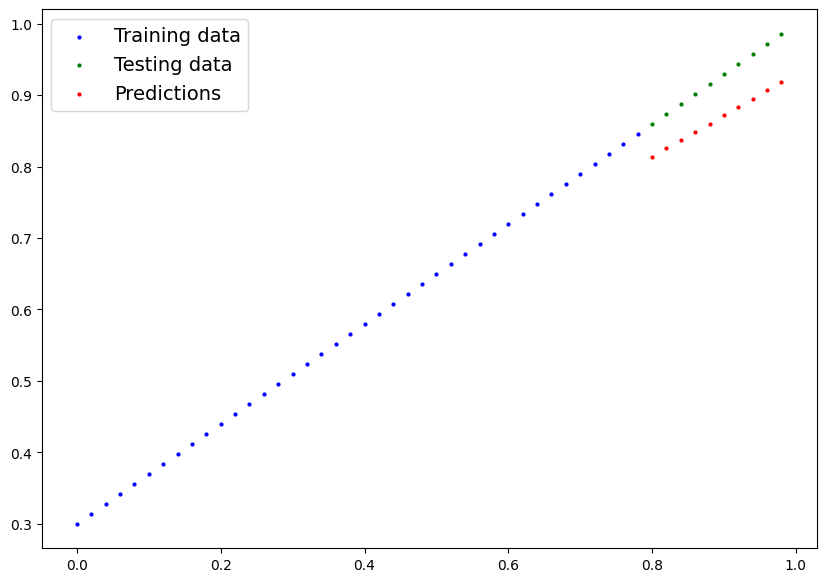

In [21]:
with torch.inference_mode():
  y_preds_new = model_0(X_test)

plot_predictions(predictions=y_preds_new)

In [22]:
import numpy as np

In [23]:
model_0.state_dict()

OrderedDict([('weights', tensor([0.5784])), ('bias', tensor([0.3513]))])

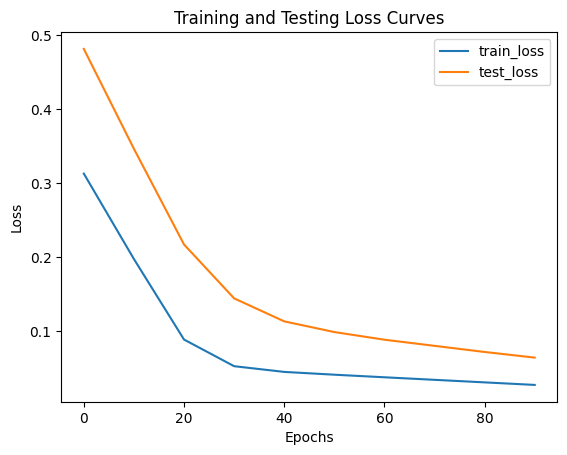

In [24]:
plt.plot(epoch_count, np.array(torch.tensor(loss_values).numpy()), label='train_loss')
plt.plot(epoch_count, test_loss_values, label='test_loss')
plt.title("Training and Testing Loss Curves")
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.legend()

## Saving the Model in PyTorch

There are three main methods you should about for saving and loading models in PyT.

1) `torch.save()` - allows you to save a PyTorch object in Python's pickle format, pickle module implements binary protocols for serializing and de-serializing a Python object structure

2) `torch.load()` - allows you to load a saved PyTorch object.

3) `torch.nn.Module.load_state_dict()` - this allows to load a model's saved state dictionary

In [25]:
# Saving our model
from pathlib import Path # python module for dealing with file paths

# 1. create model directory
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True) # if it already exists, wont give us an error

# 2. create model save path
MODEL_NAME = "01model_linear_regression.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

MODEL_SAVE_PATH

# 3. save the model's state dict
torch.save(obj = model_0.state_dict(), f=MODEL_SAVE_PATH)


In [26]:
!ls -l models

total 4
-rw-r--r-- 1 root root 1668 Jun 25 05:19 01model_linear_regression.pth


### Loading the model

Since we saved our model's state dict, we'll create a new instance of our model calss and load the saved state dict into that.

In [29]:
# to load, we have to instantiate a new instance of our model class

loaded_model_0 = LinearRegressionModel()

# load (this will update the new instance with updated parameters)

loaded_model_0.load_state_dict(torch.load(f=MODEL_SAVE_PATH))

<All keys matched successfully>

In [31]:
loaded_model_0.state_dict()

OrderedDict([('weights', tensor([0.5784])), ('bias', tensor([0.3513]))])

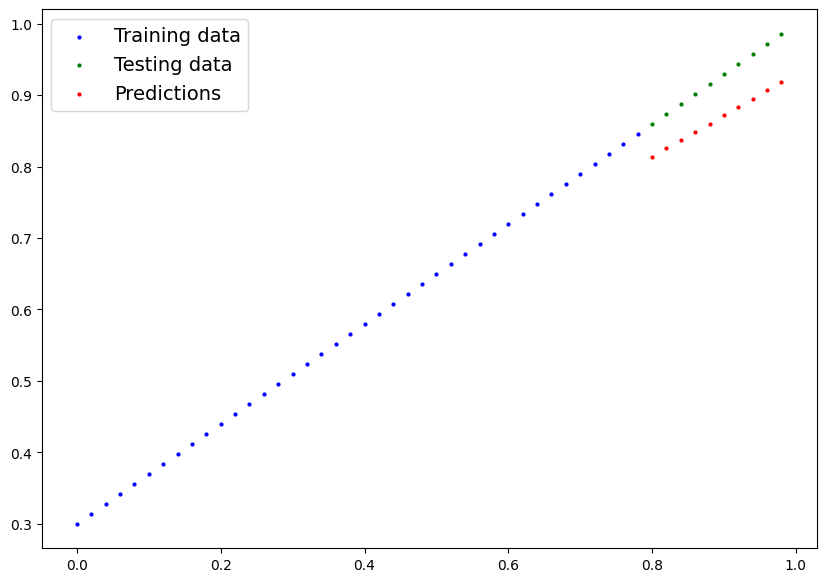

In [33]:

loaded_model_0.eval()
with torch.inference_mode():
  loaded_model_preds = loaded_model_0(X_test)
  plot_predictions(predictions = loaded_model_preds)

In [35]:
y_preds == loaded_model_preds

tensor([[True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True]])

## 6 Putting it all together

In [36]:
# Import PyTorch and matplotlib

import numpy as np
import torch
from torch import nn
import matplotlib.pyplot as plt

# Check torch version
torch.__version__

'2.6.0+cu124'

##### Create device agnostic code.

This mean if we have got access to GPU, our code will use it (for potentially faster computing)

if no GPU is available, the code will default to using CPU

In [37]:
# Setup device agnostic code

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

Using device: cuda


### 6.1 Data

In [40]:
# Create some data using the linear regression formula of y = weight * x + bias

weight = 0.6
bias = 0.4

# Create range values

start = 0
end = 1
step = 0.02

# Create X and y (features and labels)
X = torch.arange(start, end, step).unsqueeze(dim=1)
y = weight * X + bias

In [42]:
# Splitting the data

train_split = int(0.8 * int(len(X)))
X_train, y_train = X[:train_split], y[:train_split]
X_test, y_test = X[train_split:], y[train_split:]
len(X_train), len(y_train), len(X_test), len(y_test)

(40, 40, 10, 10)

In [43]:
def plot_predictions(train_data = X_train, train_labels = y_train,
                     test_data = X_test, test_labels = y_test, predictions=None):
  """Plots training data, test data and compares predictions."""
  plt.figure(figsize=(10,7))

  plt.scatter(train_data, train_labels, c="b", s=4, label="Training data")

  plt.scatter(test_data, test_labels, c="g", s=4, label="Testing data")

  if predictions is not None:
    # Plot predictions if they exist
    plt.scatter(test_data, predictions, c="r", s=4, label="Predictions")

  plt.legend(prop={"size": 14})

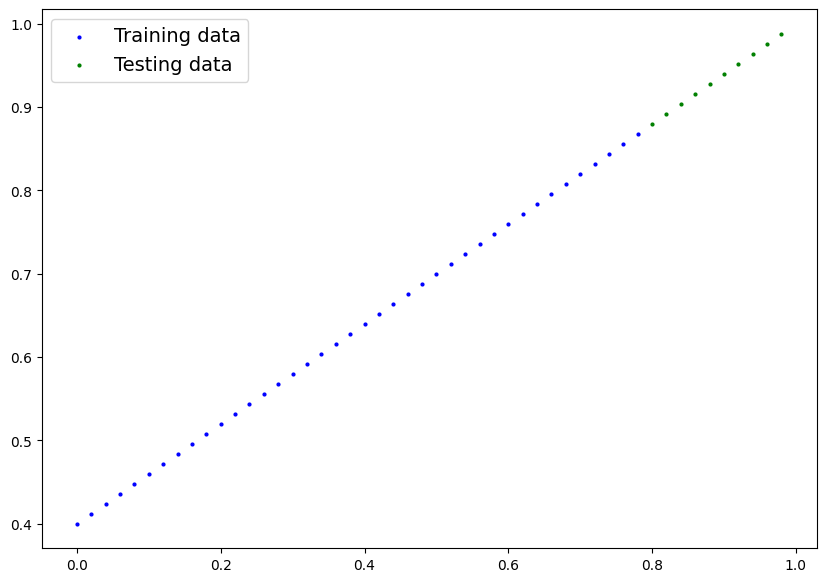

In [45]:
 plot_predictions()

### 6.2 Building a PyTorch Linear Model

In [46]:
# create a linear model by subclassing nn.Module

class LinearRegressionModelV2(nn.Module):
  def __init__(self):
    super().__init__()
    # instead of initializing parameters, use a linear layer - nn.Linear()
    self.linear_layer = nn.Linear(in_features = 1, out_features=1) # one value of X gives out one value of y, it is implementing LR for us
    # also called linear transform, probing layer, fully connected layer, dense layer (in tensorflow)

  def forward(self, x: torch.Tensor) -> torch.Tensor:
    return self.linear_layer(x)

# Set the manual seed

torch.manual_seed(42)
model_1 = LinearRegressionModelV2()
model_1, model_1.state_dict()

(LinearRegressionModelV2(
   (linear_layer): Linear(in_features=1, out_features=1, bias=True)
 ),
 OrderedDict([('linear_layer.weight', tensor([[0.7645]])),
              ('linear_layer.bias', tensor([0.8300]))]))

In [47]:
# Check the model current device
next(model_1.parameters()).device

device(type='cpu')

In [49]:
# Set the model to use the target device

model_1.to(device)
next(model_1.parameters()).device

device(type='cuda', index=0)

### 6.3 Training

For training we need a loss function, an optimizer and a training and testing loop.

In [50]:
# Set up loss function

loss_fn = nn.L1Loss()

# Set up optimizer

optimizer = torch.optim.SGD(params=model_1.parameters(), lr = 0.01)

In [51]:
# Let's write a training loop

torch.manual_seed(42)

epochs = 200

# Put data on the device (GPU rn its still on CPU, while our model is on cuda) - device agnostic code
X_train = X_train.to(device)
y_train = y_train.to(device)
X_test = X_test.to(device)
y_test = y_test.to(device)


for epoch in range(epochs):

  model_1.train()

  # 1. Forward pass
  y_pred = model_1(X_train)

  # 2. Calculate the loss
  loss = loss_fn(y_pred, y_train)

  # 3. Optimizer zero grad
  optimizer.zero_grad()

  # 4. Backprop
  loss.backward()

  # 5. Optimizer
  optimizer.step()

  ### Testing:
  model_1.eval()
  with torch.inference_mode():
    test_pred = model_1(X_test)

    test_loss = loss_fn(test_pred,y_test)

  # Print out
  if epoch % 20 == 0:
    print(f'Epoch: {epoch} | Loss: {loss} | Test Loss: {test_loss}')
    print(model_1.state_dict())

Epoch: 0 | Loss: 0.494177907705307 | Test Loss: 0.5629762411117554
OrderedDict([('linear_layer.weight', tensor([[0.7606]], device='cuda:0')), ('linear_layer.bias', tensor([0.8200], device='cuda:0'))])
Epoch: 20 | Loss: 0.26375818252563477 | Test Loss: 0.2935565710067749
OrderedDict([('linear_layer.weight', tensor([[0.6826]], device='cuda:0')), ('linear_layer.bias', tensor([0.6200], device='cuda:0'))])
Epoch: 40 | Loss: 0.033338434994220734 | Test Loss: 0.024136889725923538
OrderedDict([('linear_layer.weight', tensor([[0.6046]], device='cuda:0')), ('linear_layer.bias', tensor([0.4200], device='cuda:0'))])
Epoch: 60 | Loss: 0.009796462021768093 | Test Loss: 0.00330507755279541
OrderedDict([('linear_layer.weight', tensor([[0.5968]], device='cuda:0')), ('linear_layer.bias', tensor([0.3995], device='cuda:0'))])
Epoch: 80 | Loss: 0.009796462021768093 | Test Loss: 0.00330507755279541
OrderedDict([('linear_layer.weight', tensor([[0.5968]], device='cuda:0')), ('linear_layer.bias', tensor([0.399

In [52]:
model_1.state_dict()

OrderedDict([('linear_layer.weight', tensor([[0.6007]], device='cuda:0')),
             ('linear_layer.bias', tensor([0.4095], device='cuda:0'))])

In [53]:
weight, bias

(0.6, 0.4)

### 6.4 Making and evaluating predictions

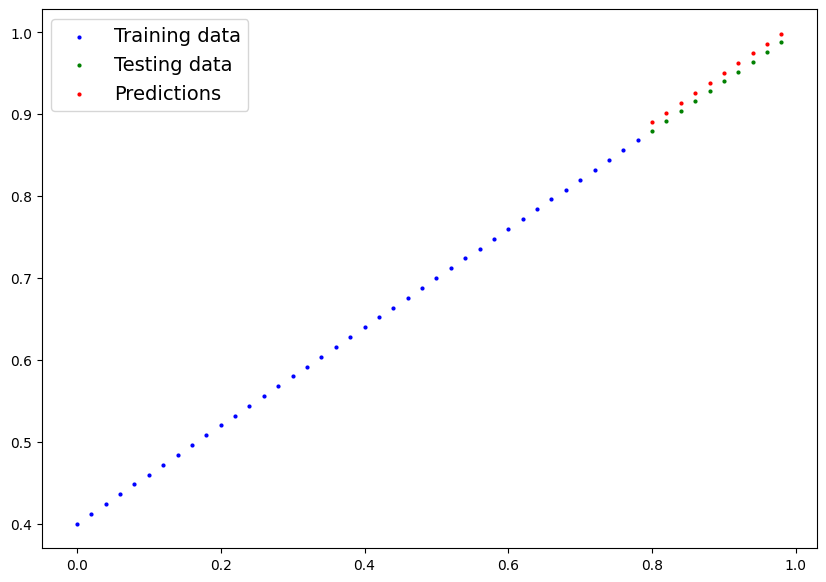

In [63]:
# Turn into eval mode
model_1.eval()

with torch.inference_mode():
  y_preds = model_1(X_test)
  y_preds = y_preds.to("cpu")
  plot_predictions(predictions = y_preds)
  # or plot_predictions(predictions = y_preds.cpu())

### 6.5 Saving and loading a trained model

In [64]:
from pathlib import Path


# 1. create model directory
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True) # if it already exists, wont give us an error

# 2. create model save path
MODEL_NAME = "01model_linear_regression_v2.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

MODEL_SAVE_PATH

# 3. save the model's state dict
torch.save(obj = model_1.state_dict(), f=MODEL_SAVE_PATH)

In [68]:
# Load a Pytorch model

model_1_v2 = LinearRegressionModelV2()

model_1_v2.load_state_dict(torch.load(f=MODEL_SAVE_PATH))

# Put loaded model on device
model_1_v2.to(device)

LinearRegressionModelV2(
  (linear_layer): Linear(in_features=1, out_features=1, bias=True)
)

In [69]:
model_1_v2.state_dict()

OrderedDict([('linear_layer.weight', tensor([[0.6007]], device='cuda:0')),
             ('linear_layer.bias', tensor([0.4095], device='cuda:0'))])

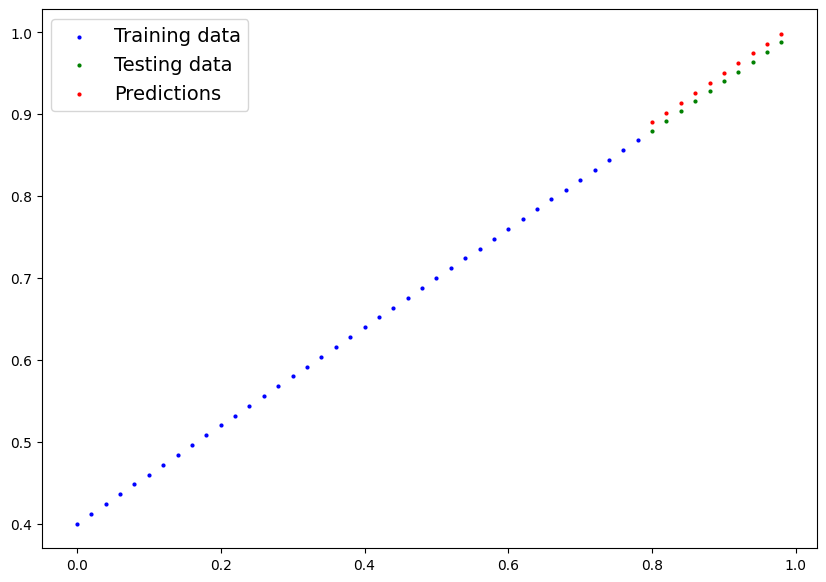

In [70]:
# Evaluate laoded model
model_1_v2.eval()

with torch.inference_mode():
  loaded_preds = model_1_v2(X_test)
  plot_predictions(predictions = loaded_preds.cpu())

In [72]:
y_preds.cpu() == loaded_preds.cpu()

tensor([[True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True]])